#**CUSTOMER SEGMENTATION USING K-PROTOTYPE**



## **Problem Statement**
With rising competition and evolving customer expectations, insurers leverage data-driven intelligence to understand customer behavior and tailor their offerings accordingly. Customer segmentation provides a structured way to group individuals with shared characteristics, enabling more efficient targeting and  marketing strategies.

In this project, we perform customer segmentation using the K-Prototypes clustering algorithm, which effectively handles mixed numerical and categorical data such as demographics, income, spending behavior, and policy attributes. After identifying the underlying clusters, Gemini AI is employed to interpret each group’s defining traits and generate concise, meaningful segment names and descriptions. The resulting customer groups — Young Independent Starters, Affluent Independent Navigators and Loyal Established Households, offer the company actionable insights that support personalized marketing, retention strategies, and strategic product positioning.


# (1) Import Libraries

In [ ]:
!pip install kmodes # install kmodes for KPrototypes algorithm

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize, OneHotEncoder
from kmodes.kprototypes import KPrototypes
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas_gbq import read_gbq

In [ ]:
import random

# Fix global seeds
np.random.seed(42)
random.seed(42)

In [ ]:
import os

# read environment variable when running Github Action where we defined RUN_GENAI as false
# not run Gen AI block if checked RUN_GENAI is false
RUN_GENAI = os.getenv("RUN_GENAI", "false").lower() == "true"
print("RUN_GENAI =", RUN_GENAI)

RUN_GENAI = False


# (2) Import Dataset
First, we collect customer, sales and product data from the three spreadsheets stored in Google Sheet, namely 1) customers.csv, 2) sales.csv and 3) products.csv, respectively.

In [ ]:
# Extract the customer data from a csv file in Google Sheet
df_customers = pd.read_csv('https://docs.google.com/spreadsheets/d/1bzB4VDQEQz0BIbyT2BCIvcE2rPSAlOcmeQuvMtuIFcI/export?format=csv')
df_customers

,Customer_ID,Age,Gender,City,Marital_Status,Education,Occupation,Income,Preferred_Language,Preferred_Channel,Preferred_Time
0,HL00001,41,Male,Sheffield,Single,Associate Degree,Lawyer,18719.316,French,Email,Afternoon
1,HL00002,50,Female,Manchester,Married,Doctorate,Entrepreneur,59456.052,English,Email,Afternoon
2,HL00003,33,Female,London,Divorced,Doctorate,Lawyer,61078.656,Arabic,Email,Morning
3,HL00004,43,Male,Edinburgh,Married,Master's Degree,Lawyer,39333.528,English,Email,Evening
4,HL00005,36,Male,Liverpool,Separated,Bachelor's Degree,Nurse,25995.516,English,Mail,Evening
...,...,...,...,...,...,...,...,...,...,...,...
3441,HL03442,42,Male,Bristol,Single,Master's Degree,Manager,48832.356,English,Email,Anytime
3442,HL03443,18,Male,Leeds,Divorced,Associate Degree,Doctor,127478.040,English,Email,Afternoon
3443,HL03444,34,Female,London,Divorced,Doctorate,Entrepreneur,97274.124,Chinese,In-Person Meeting,Morning
3444,HL03445,54,Female,Belfast,Married,Bachelor's Degree,Manager,66348.840,English,Phone,Anytime


In [ ]:
# Extract the sales data from a csv file in Google Sheet
df_sales = pd.read_csv('https://docs.google.com/spreadsheets/d/1xrPtoy8R965CPSCS59_hcLP1cwzNcp7DJ2MOegZrsVA/export?format=csv')
df_sales

,Policy_ID,Customer_ID,Product_ID,Purchase_Date,Premium,Coverage
0,P000008,HL00008,POL200008,5/4/2022,861.832800,97928.79508
1,P000010,HL00010,POL200016,3/17/2022,1294.144416,100724.49880
2,P000015,HL00015,POL200017,5/19/2022,2470.369199,102937.51920
3,P000019,HL00019,POL200018,8/3/2022,2032.112144,98439.34626
4,P000022,HL00022,POL200015,5/24/2023,1156.180369,101259.37510
...,...,...,...,...,...,...
3459,P003458,HL03367,POL200009,22/01/2022,5375.637343,519777.85190
3460,P003459,HL03367,POL200001,16/09/2021,4798.328801,336051.20600
3461,P003462,HL00347,POL200001,6/26/2011,5465.828597,382502.92070
3462,P003463,HL00347,POL200016,6/11/2012,5015.488343,396869.88540


In [ ]:
# Extract the products data from a csv file in Google Sheet
df_products = pd.read_csv('https://docs.google.com/spreadsheets/d/1HpCKgERS0F9qjHh3y0_GZ988JjX4vtKBX5rIksCgB5I/gviz/tq?tqx=out:csv&gid=0')
df_products

,Product_ID,Product_Name,Product_Type,Category
0,POL200000,WellBeing Cover,Health,Group
1,POL200001,MediAssist,Health,Group
2,POL200002,FamilyLife Plus,Life,Group
3,POL200003,LifeShield,Life,Group
4,POL200004,SecureLegacy,Life,Group
5,POL200005,DriveSure,Auto,Group
6,POL200006,TradeSecure,Property,Business
7,POL200007,AssetShield,Property,Business
8,POL200008,OfficeProtect,Property,Business
9,POL200009,MotorShield,Auto,Business


# (3) Data Cleaning
This section performs an initial exploratory check on the three datasets — customers, sales, and products — to understand their structure and data quality. We inspect the columns, data types, and non-null counts for each dataset, ensuring that all expected fields are present and correctly formatted. Then we check for missing values and any duplicate rows. This process provides a quick overview of the data completeness and consistency before proceeding to further preprocessing or analysis.

In [ ]:
# Check the columns and datatypes of customers data
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446 entries, 0 to 3445
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         3446 non-null   object 
 1   Age                 3446 non-null   int64  
 2   Gender              3446 non-null   object 
 3   City                3446 non-null   object 
 4   Marital_Status      3446 non-null   object 
 5   Education           3446 non-null   object 
 6   Occupation          3446 non-null   object 
 7   Income              3446 non-null   float64
 8   Preferred_Language  3446 non-null   object 
 9   Preferred_Channel   3446 non-null   object 
 10  Preferred_Time      3446 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 296.3+ KB


In [ ]:
# Check the columns and datatypes of sales data
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3464 entries, 0 to 3463
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Policy_ID      3464 non-null   object 
 1   Customer_ID    3464 non-null   object 
 2   Product_ID     3464 non-null   object 
 3   Purchase_Date  3464 non-null   object 
 4   Premium        3464 non-null   float64
 5   Coverage       3464 non-null   float64
dtypes: float64(2), object(4)
memory usage: 162.5+ KB


In [ ]:
# Check the columns and datatypes of products data
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Product_ID    19 non-null     object
 1   Product_Name  19 non-null     object
 2   Product_Type  19 non-null     object
 3   Category      19 non-null     object
dtypes: object(4)
memory usage: 740.0+ bytes


In [ ]:
# Check for missing values for customers data
df_customers.isnull().sum()

,0
Customer_ID,0
Age,0
Gender,0
City,0
Marital_Status,0
Education,0
Occupation,0
Income,0
Preferred_Language,0
Preferred_Channel,0


In [ ]:
# Check for missing values for sales data
df_sales.isnull().sum()

,0
Policy_ID,0
Customer_ID,0
Product_ID,0
Purchase_Date,0
Premium,0
Coverage,0


In [ ]:
# Check for missing values for products data
df_products.isnull().sum()

,0
Product_ID,0
Product_Name,0
Product_Type,0
Category,0


In [ ]:
# Check if any duplicated rows
df_customers.duplicated().sum()

np.int64(0)

In [ ]:
# Check if any duplicated rows
df_sales.duplicated().sum()

np.int64(0)

In [ ]:
# Check if any duplicated rows
df_products.duplicated().sum()

np.int64(0)

# (4) Data Wraggling and Visualization
We further derive key metrics from the existing data, including customer loyalty (represented by the *Tenure_Years* column) and insurer profitability (captured through the *Premium_to_Coverage* ratio). These metrics provide insight into how long customers have been with the company and how much value they generate relative to their coverage. After computing these measures, we explored the distribution of both categorical and numerical variables to better understand customer demographics, purchasing behavior, and overall trends within the dataset.

In [ ]:
# Find the loyalty of the customers by calculating the number of years the customers purchased the policy

# Convert 'Purchase_History' to pandas datetime format
df_sales['Purchase_Date'] = pd.to_datetime(df_sales['Purchase_Date'], format='mixed')

# Get today's date as a pandas Timestamp
today = pd.Timestamp.today()

# Convert 'Purchase_History' to individual timestamps before subtracting
df_sales['Tenure_Years'] = (today - df_sales['Purchase_Date'].astype('datetime64[ns]')).dt.days / 365

df_sales['Tenure_Years'] = df_sales['Tenure_Years'].round(2)

In [ ]:
# Calculate premium to coverage ratio which shows the profitability for insurance company
# Higher the ratio, higher the amount customers willing to pay their premiums
# relative to the amount of coverage they are receiving

df_sales['Premium_to_Coverage'] = df_sales['Premium']/ df_sales['Coverage']*100
df_sales

,Policy_ID,Customer_ID,Product_ID,Purchase_Date,Premium,Coverage,Tenure_Years,Premium_to_Coverage
0,P000008,HL00008,POL200008,2022-05-04,861.832800,97928.79508,3.62,0.880061
1,P000010,HL00010,POL200016,2022-03-17,1294.144416,100724.49880,3.75,1.284836
2,P000015,HL00015,POL200017,2022-05-19,2470.369199,102937.51920,3.58,2.399872
3,P000019,HL00019,POL200018,2022-08-03,2032.112144,98439.34626,3.37,2.064329
4,P000022,HL00022,POL200015,2023-05-24,1156.180369,101259.37510,2.56,1.141801
...,...,...,...,...,...,...,...,...
3459,P003458,HL03367,POL200009,2022-01-22,5375.637343,519777.85190,3.90,1.034218
3460,P003459,HL03367,POL200001,2021-09-16,4798.328801,336051.20600,4.25,1.427856
3461,P003462,HL00347,POL200001,2011-06-26,5465.828597,382502.92070,14.48,1.428964
3462,P003463,HL00347,POL200016,2012-06-11,5015.488343,396869.88540,13.52,1.263761


In [ ]:
# merge the sales and customers data for clustering
df_merged = pd.merge(df_sales, df_customers, on='Customer_ID', how='left')
df_merged

,Policy_ID,Customer_ID,Product_ID,Purchase_Date,Premium,Coverage,Tenure_Years,Premium_to_Coverage,Age,Gender,City,Marital_Status,Education,Occupation,Income,Preferred_Language,Preferred_Channel,Preferred_Time
0,P000008,HL00008,POL200008,2022-05-04,861.832800,97928.79508,3.62,0.880061,31,Female,Cardiff,Single,Associate Degree,Nurse,12648.5040,Portuguese,Text,Anytime
1,P000010,HL00010,POL200016,2022-03-17,1294.144416,100724.49880,3.75,1.284836,49,Male,Stoke-on-Trent,Married,Doctorate,Artist,54920.5920,English,Mail,Morning
2,P000015,HL00015,POL200017,2022-05-19,2470.369199,102937.51920,3.58,2.399872,42,Female,London,Widowed,Doctorate,Lawyer,43274.9280,English,Text,Evening
3,P000019,HL00019,POL200018,2022-08-03,2032.112144,98439.34626,3.37,2.064329,41,Female,Manchester,Widowed,Doctorate,Lawyer,47331.2040,English,Text,Evening
4,P000022,HL00022,POL200015,2023-05-24,1156.180369,101259.37510,2.56,1.141801,20,Female,Birmingham,Married,Bachelor's Degree,Entrepreneur,7628.8212,English,Text,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459,P003458,HL03367,POL200009,2022-01-22,5375.637343,519777.85190,3.90,1.034218,56,Female,London,Married,Bachelor's Degree,Manager,64186.7640,English,Phone,Weekends
3460,P003459,HL03367,POL200001,2021-09-16,4798.328801,336051.20600,4.25,1.427856,56,Female,London,Married,Bachelor's Degree,Manager,64186.7640,English,Phone,Weekends
3461,P003462,HL00347,POL200001,2011-06-26,5465.828597,382502.92070,14.48,1.428964,50,Female,Manchester,Married,Bachelor's Degree,Manager,87828.2280,English,Text,Anytime
3462,P003463,HL00347,POL200016,2012-06-11,5015.488343,396869.88540,13.52,1.263761,50,Female,Manchester,Married,Bachelor's Degree,Manager,87828.2280,English,Text,Anytime


In [ ]:
# group the data by customer and average the metrics for each customer
df_grouped_customer = df_merged.groupby(['Customer_ID', 'Marital_Status']).agg(
                      Age = ('Age', 'mean'),
                      Income = ('Income', 'mean'),
                      Tenure_Years = ('Tenure_Years', 'mean'),
                      Premium_to_Coverage = ('Premium_to_Coverage',  'mean')
)

In [ ]:
df_grouped_customer = df_grouped_customer.reset_index() # reset the index to free the columns
df_grouped_customer

,Customer_ID,Marital_Status,Age,Income,Tenure_Years,Premium_to_Coverage
0,HL00001,Single,41.0,18719.316,11.21,1.236672
1,HL00002,Married,50.0,59456.052,1.82,0.794987
2,HL00003,Divorced,33.0,61078.656,3.65,0.902040
3,HL00004,Married,43.0,39333.528,3.02,0.719727
4,HL00005,Separated,36.0,25995.516,10.96,0.954749
...,...,...,...,...,...,...
3441,HL03442,Single,42.0,48832.356,4.74,0.774854
3442,HL03443,Divorced,18.0,127478.040,4.61,0.864231
3443,HL03444,Divorced,34.0,97274.124,4.85,0.811720
3444,HL03445,Married,54.0,66348.840,14.24,0.852235


In [ ]:
# Extract the columns that are useful for the analysis
df = df_grouped_customer[['Age', 'Marital_Status','Income','Tenure_Years', 'Premium_to_Coverage']].copy()

In [ ]:
df

,Age,Marital_Status,Income,Tenure_Years,Premium_to_Coverage
0,41.0,Single,18719.316,11.21,1.236672
1,50.0,Married,59456.052,1.82,0.794987
2,33.0,Divorced,61078.656,3.65,0.902040
3,43.0,Married,39333.528,3.02,0.719727
4,36.0,Separated,25995.516,10.96,0.954749
...,...,...,...,...,...
3441,42.0,Single,48832.356,4.74,0.774854
3442,18.0,Divorced,127478.040,4.61,0.864231
3443,34.0,Divorced,97274.124,4.85,0.811720
3444,54.0,Married,66348.840,14.24,0.852235


In [ ]:
# Identify the columns with categorical and numeric labels
categorical_cols = ['Marital_Status']
numerical_cols = ['Age', 'Income', 'Tenure_Years', 'Premium_to_Coverage']

In [ ]:
# Define categorical column indices
categorical_indices = [df.columns.get_loc(col) for col in categorical_cols]
categorical_indices

[1]

In [ ]:
# Define categorical column indices
numeric_indices = [df.columns.get_loc(col) for col in numerical_cols]
numeric_indices

[0, 2, 3, 4]

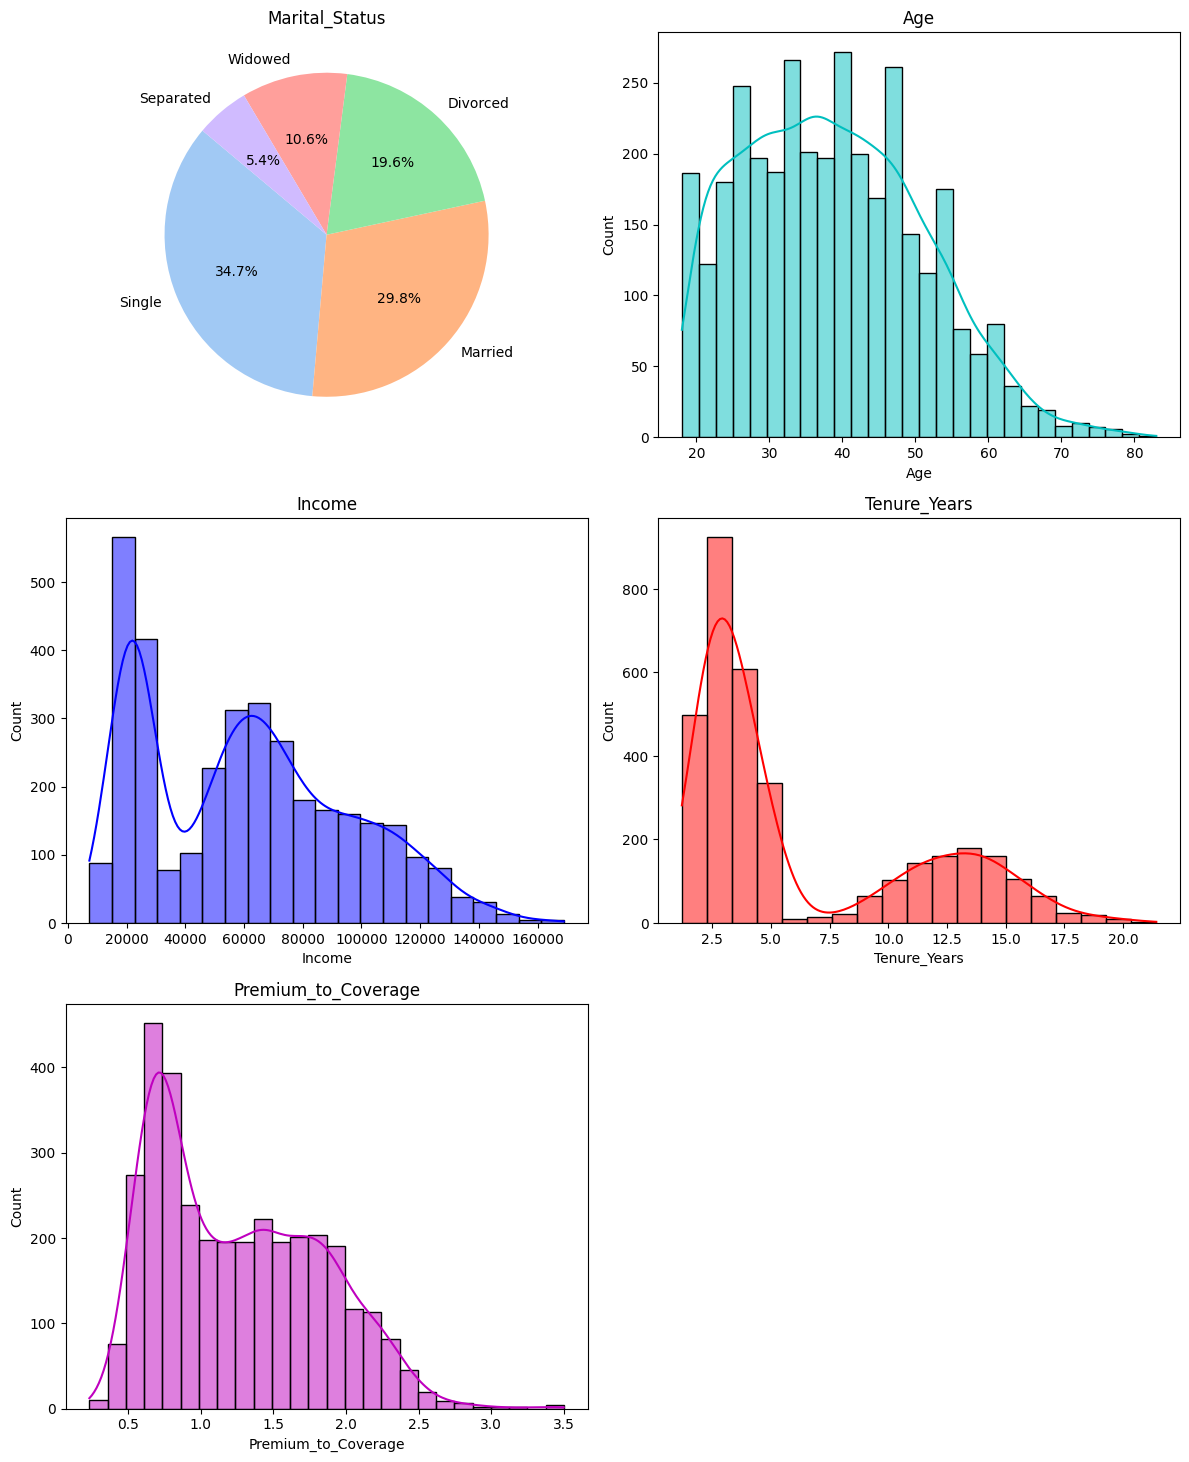

In [ ]:
# Shows the distribution of each feature

plt.figure(figsize=(12, 24))
colours_val = ['c', 'b', 'r', 'm']

length = len(categorical_indices) + len(numerical_cols)

# Pie Charts for Categorical Features
for j, i in enumerate(categorical_indices):
    plt.subplot(length, 2, j + 1)
    value_counts = df.iloc[:, i].value_counts()
    plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%',
            colors=sns.color_palette("pastel"), startangle=140)
    plt.title(df.columns[i])

# Histograms for Numerical Features
for j, i in enumerate(numeric_indices):
    plt.subplot(length, 2, len(categorical_indices) + j + 1)
    sns.histplot(df.iloc[:, i], kde=True, color=colours_val[j])
    plt.title(df.columns[i])

plt.tight_layout()
plt.show()

# (5) Feature Engineering

Due to a mix of categorical and numeric data, we prefer K-Prototype to K-means for the segmentation, as the latter only works for numerical data. Before data clustering, we may need to transform raw data into features which can be used in the model.

*   *Categorical labels*: These can be used directly in the K-Prototypes algorithm without any conversion, as it is designed to handle categorical features natively through matching dissimilarities.

*   *Numerical labels*: Scale the numerical features to a range of 0 to 1 using **MinMaxScaler**. We prefer MinMaxScaler over StandardScaler because it bounds all values within the same range, ensuring that each numerical feature contributes equally to the overall distance calculation in this distance-based segmentation algorithm.



In [ ]:
df_c = df.copy()

In [ ]:
# ensure all columns with numerical values are in float data type
for col in numerical_cols:
    df_c[col] = df_c[col].astype('float64')

In [ ]:
# Statistics of the dataset
df_c.describe()

,Age,Income,Tenure_Years,Premium_to_Coverage
count,3446.000000,3446.000000,3446.000000,3446.000000
mean,38.705165,60842.116697,6.243227,1.251587
std,12.234530,34680.122498,4.865412,0.565356
min,18.000000,7343.839200,1.200000,0.233796
25%,29.000000,25272.714000,2.650000,0.747882
50%,38.000000,59751.606000,3.710000,1.169621
75%,47.000000,85128.669000,10.865000,1.699544
max,83.000000,168937.560000,21.410000,3.498307


In [ ]:
# scale the numerical variables
scaler = MinMaxScaler()
df_c[numerical_cols] = scaler.fit_transform(df_c[numerical_cols])
df_c

,Age,Marital_Status,Income,Tenure_Years,Premium_to_Coverage
0,0.353846,Single,0.070396,0.495299,0.307206
1,0.492308,Married,0.322489,0.030678,0.171907
2,0.230769,Divorced,0.332530,0.121227,0.204700
3,0.384615,Married,0.197964,0.090054,0.148853
4,0.276923,Separated,0.115423,0.482929,0.220846
...,...,...,...,...,...
3441,0.369231,Single,0.256746,0.175161,0.165740
3442,0.000000,Divorced,0.743434,0.168728,0.193118
3443,0.246154,Divorced,0.556521,0.180604,0.177033
3444,0.553846,Married,0.365144,0.645225,0.189443


In [ ]:
# convert the data to array for clustering in the next step
c_array = df_c.to_numpy()
c_array

array([[0.3538461538461538, 'Single', 0.0703955372998627,
        0.4952993567540822, 0.30720573831094333],
       [0.49230769230769234, 'Married', 0.3224890951332064,
        0.030677882236516588, 0.1719066997474958],
       [0.23076923076923073, 'Divorced', 0.3325303516372772,
        0.12122711528946066, 0.2046997214143574],
       ...,
       [0.24615384615384617, 'Divorced', 0.5565209115476967,
        0.1806036615536863, 0.17703255267571788],
       [0.5538461538461539, 'Married', 0.36514414364546266,
        0.6452251360712519, 0.1894432559380351],
       [0.1076923076923077, 'Widowed', 0.33158702290367703,
        0.2785749628896586, 0.16309617758305803]], dtype=object)

# (6) Clustering using K-Prototypes

K-prototypes combines the use of minimizing Euclidean distance for numerical labels and comparing matching dissimilarity for categorical labels, to determine the cluster centroids. We locate the optimal k (the no. of clusters) using Elbow Method, where the optimal k is the point that the rate of decrease in **WCSS (Within-Cluster Sum of Squares)** slows down or flattens. WCSS measures the total variance within each cluster.

In [ ]:
# we set k as the number of clusters

costs = {} # a dictionary to store the WCSS (Within-Cluster Sum of Square) for each k
labels = {} # a dictionary to store the predicted cluster labels for each k

range_of_k = range(2,10) # we set k from 2 to 9
for k in range_of_k :
    print("Checking k =", k)
    untrained_model = KPrototypes(n_clusters=k, init='Cao', max_iter=20, random_state=42, verbose=1) # fixed random seed
    trained_model = untrained_model.fit(c_array, categorical=categorical_indices)

    labels[k] = trained_model.labels_ # predicted labels
    costs[k]=trained_model.cost_ # WCSS

Checking k = 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 544, ncost: 550.6781230576776
Run: 1, iteration: 2/20, moves: 68, ncost: 550.2686812128335
Run: 1, iteration: 3/20, moves: 18, ncost: 550.2056189664319
Run: 1, iteration: 4/20, moves: 3, ncost: 550.2040341824518
Run: 1, iteration: 5/20, moves: 1, ncost: 550.2038108101211
Run: 1, iteration: 6/20, moves: 0, ncost: 550.2038108101211
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/20, moves: 1092, ncost: 556.4568208915592
Run: 2, iteration: 2/20, moves: 232, ncost: 550.7413395264357
Run: 2, iteration: 3/20, moves: 53, ncost: 550.2584739468634
Run: 2, iteration: 4/20, moves: 16, ncost: 550.206337023497
Run: 2, iteration: 5/20, moves: 2, ncost: 550.2051528988368
Run: 2, iteration: 6/20, moves: 1, ncost: 550.2049299451696
Run: 2, iteration: 

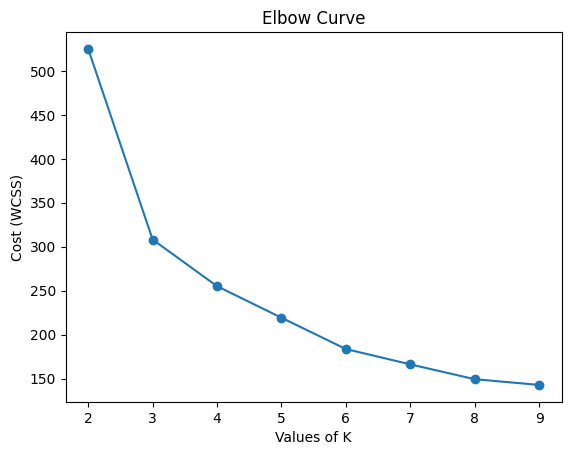

In [ ]:
# We hope to minimize the cost (i.e. WCSS)
# When k = 3, the elbow curve flattens out significantly.
# Hence, we choose the optimal no. of clustering to be 3.
plt.plot(costs.keys(), costs.values())
plt.scatter(costs.keys(),costs.values())
plt.xlabel("Values of K")
plt.ylabel("Cost (WCSS)")
plt.title("Elbow Curve")
plt.show()

# (7) Evaluation of the Model
The model’s performance is evaluated using the **Silhouette Score**. To further assess the quality of the segmentation, we visualize the clustering results in two dimensions using **Factor Analysis of Mixed Data (FAMD)** — a dimensionality reduction technique suitable for datasets containing both categorical and numerical variables. The resulting plot reveals well-defined and distinct cluster structures.

In [ ]:
# We use gower distance to calculate Silhouette Score, due to the presence of categorical data
!pip install gower

from sklearn.metrics import silhouette_score
import gower

In [ ]:
# Copy the predictions for k = 3 which we found from the WCSS chart
pred = labels[3]
customers_clustered = df.copy()
customers_clustered['Cluster'] = pred

# Compute the custom distance matrix on the sampled data to be used for calculating the Silhouette Score
# Gower distance is to measure similarity between data points
gower_dist = gower.gower_matrix(customers_clustered.drop(columns=['Cluster']))

# Extract cluster labels for calculating the Silhouette Score
cluster_labels = customers_clustered['Cluster']

# Check the Silhouette Score for k = 3
# A Silhouette Score of 0.43 shows a moderate clustering quality
sil_score = silhouette_score(gower_dist, cluster_labels, metric='precomputed')
print('Silhouette Score: ', sil_score)

Silhouette Score:  0.43433034


In [ ]:
# we use FAMD for reducing the dimensions of mixed data
!pip install prince

In [ ]:
df_c # dataframe with scaled numerical data and categorical labels

,Age,Marital_Status,Income,Tenure_Years,Premium_to_Coverage
0,0.353846,Single,0.070396,0.495299,0.307206
1,0.492308,Married,0.322489,0.030678,0.171907
2,0.230769,Divorced,0.332530,0.121227,0.204700
3,0.384615,Married,0.197964,0.090054,0.148853
4,0.276923,Separated,0.115423,0.482929,0.220846
...,...,...,...,...,...
3441,0.369231,Single,0.256746,0.175161,0.165740
3442,0.000000,Divorced,0.743434,0.168728,0.193118
3443,0.246154,Divorced,0.556521,0.180604,0.177033
3444,0.553846,Married,0.365144,0.645225,0.189443


In [ ]:
# reduced the dimensionality to 2-D for visualing the clustering
from prince import FAMD

famd = FAMD(n_components=2, random_state=42)
X_famd = famd.fit_transform(df_c)

X_famd #2-D

component,0,1
0,-0.279237,0.970623
1,0.512036,-0.307947
2,-0.055975,-1.068376
3,0.053129,-0.155772
4,0.155939,0.225473
...,...,...
3441,0.030294,-0.523463
3442,0.313372,-2.132985
3443,0.685990,-1.411411
3444,1.787690,1.221379


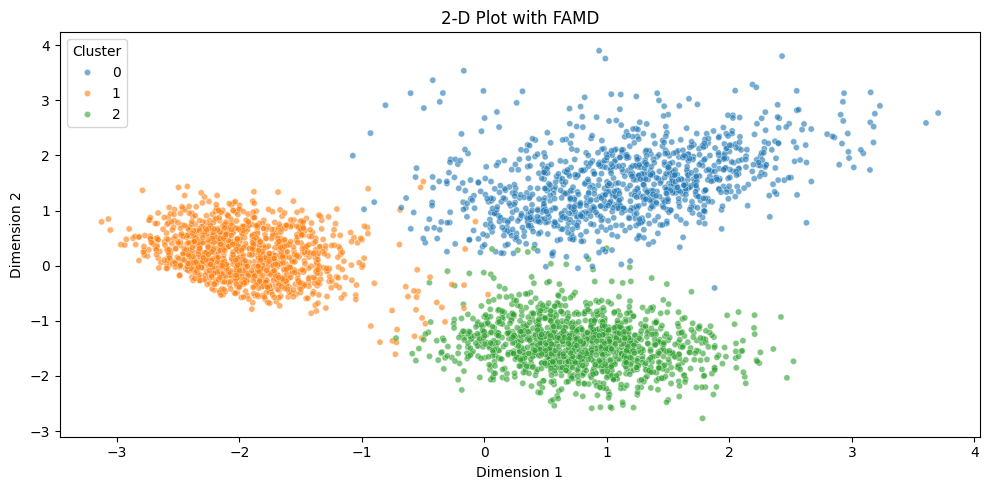

In [ ]:
# Add cluster labels to the FAMD result for plotting
X_famd['Cluster'] = pred

# Scatter plot of the 2D data
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data = X_famd,
    x = X_famd.columns[0],
    y = X_famd.columns[1],
    hue ='Cluster',
    palette ='tab10',
    s = 20,
    alpha = 0.6,
)

plt.title("2-D Plot with FAMD")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.tight_layout()
plt.show()


# (8) Analysis of the Customer Segments
After clustering the customers into three distinct segments, we analyze each group’s demographic and policy-related characteristics to better understand their unique profiles. We then use Gemini AI to generate descriptive cluster labels and segment descriptions by providing the summarized metrics of each segment, with the Gemini API key securely stored in Colab’s secret manager.

In [ ]:
customers_clustered

,Age,Marital_Status,Income,Tenure_Years,Premium_to_Coverage,Cluster
0,41.0,Single,18719.316,11.21,1.236672,0
1,50.0,Married,59456.052,1.82,0.794987,2
2,33.0,Divorced,61078.656,3.65,0.902040,2
3,43.0,Married,39333.528,3.02,0.719727,2
4,36.0,Separated,25995.516,10.96,0.954749,0
...,...,...,...,...,...,...
3441,42.0,Single,48832.356,4.74,0.774854,1
3442,18.0,Divorced,127478.040,4.61,0.864231,2
3443,34.0,Divorced,97274.124,4.85,0.811720,2
3444,54.0,Married,66348.840,14.24,0.852235,0


In [ ]:
!pip install -q -U google-genai

In [ ]:
from google.colab import userdata
import google.genai as genai

# Try Colab userdata
try:
    from google.colab import userdata
    api_key = userdata.get('GEMINI_API_KEY')
except Exception:
    # Fallback: use environment variable (GitHub Actions, local)
    api_key = os.getenv("GEMINI_API_KEY")

client = genai.Client(api_key=api_key) # Create the Gemini client

In [ ]:
# Summarize the features for each cluster
customers_clustered.groupby('Cluster').agg({
    "Age": "mean",
    "Marital_Status": lambda x: x.value_counts().index[0], # mode of marital status
    "Income": "mean",
    "Tenure_Years": "mean",
    "Premium_to_Coverage": "mean",
})


,Age,Marital_Status,Income,Tenure_Years,Premium_to_Coverage
Cluster,,,,,
0,50.215238,Married,59883.644438,13.108858,1.352426
1,26.738707,Single,22475.806389,2.812161,1.782404
2,39.829519,Divorced,95823.932174,3.610837,0.695017


In [ ]:
# rename the columns
cluster_summary = (
    customers_clustered
    .groupby('Cluster')
    .agg({
        "Age": "mean",
        "Marital_Status": lambda x: x.value_counts().index[0],
        "Income": "mean",
        "Tenure_Years": "mean",
        "Premium_to_Coverage": "mean",
    })
    .rename(columns={
        "Age": "Age_avg",
        "Marital_Status": "Marital_Status_mode",
        "Income": "Income_avg",
        "Tenure_Years": "Tenure_Years_avg",
        "Premium_to_Coverage": "Premium_to_Coverage_avg",
    })
    .reset_index()
)

cluster_summary


,Cluster,Age_avg,Marital_Status_mode,Income_avg,Tenure_Years_avg,Premium_to_Coverage_avg
0,0,50.215238,Married,59883.644438,13.108858,1.352426
1,1,26.738707,Single,22475.806389,2.812161,1.782404
2,2,39.829519,Divorced,95823.932174,3.610837,0.695017


In [ ]:
# Due to the randomness of cluster id, sort clusters by Age_avg
cluster_summary_sorted = cluster_summary.sort_values(
    ["Age_avg"], ascending=[True]
).reset_index(drop=True)

# Assign deterministic IDs
cluster_summary_sorted["Cluster_ID"] = range(len(cluster_summary_sorted))
cluster_summary_sorted

,Cluster,Age_avg,Marital_Status_mode,Income_avg,Tenure_Years_avg,Premium_to_Coverage_avg,Cluster_ID
0,1,26.738707,Single,22475.806389,2.812161,1.782404,0
1,2,39.829519,Divorced,95823.932174,3.610837,0.695017,1
2,0,50.215238,Married,59883.644438,13.108858,1.352426,2


In [ ]:
# Create mapping rule for converting old cluster IDs to new ones
id_map = dict(
    zip(cluster_summary_sorted["Cluster"], cluster_summary_sorted["Cluster_ID"])
)

id_map

{1: 0, 2: 1, 0: 2}

In [ ]:
# Drop the old cluster ID, replaced by new cluster ID based on the average age
cluster_summary_sorted = cluster_summary_sorted.drop(['Cluster'], axis=1)
cluster_summary_sorted

,Age_avg,Marital_Status_mode,Income_avg,Tenure_Years_avg,Premium_to_Coverage_avg,Cluster_ID
0,26.738707,Single,22475.806389,2.812161,1.782404,0
1,39.829519,Divorced,95823.932174,3.610837,0.695017,1
2,50.215238,Married,59883.644438,13.108858,1.352426,2


In [ ]:
# Apply mapping rule to convert old cluster IDs to new IDs in the customer dataset
customers_clustered["Cluster_ID"] = customers_clustered["Cluster"].map(id_map)

customers_clustered = customers_clustered.drop(columns=['Cluster'])

customers_clustered

,Age,Marital_Status,Income,Tenure_Years,Premium_to_Coverage,Cluster_ID
0,41.0,Single,18719.316,11.21,1.236672,2
1,50.0,Married,59456.052,1.82,0.794987,1
2,33.0,Divorced,61078.656,3.65,0.902040,1
3,43.0,Married,39333.528,3.02,0.719727,1
4,36.0,Separated,25995.516,10.96,0.954749,2
...,...,...,...,...,...,...
3441,42.0,Single,48832.356,4.74,0.774854,0
3442,18.0,Divorced,127478.040,4.61,0.864231,1
3443,34.0,Divorced,97274.124,4.85,0.811720,1
3444,54.0,Married,66348.840,14.24,0.852235,2


In [ ]:
# Function for asking Gemini for the cluster names and descriptions
import json
import re

def get_cluster_labels_from_gemini(summary_df):
    # Turn the cluster summary into a list of dicts
    data = summary_df.to_dict(orient="records")

    prompt = f"""
You are a marketing analyst for an insurance company.

You will receive a list of customer clusters with summary statistics.
Each record has:
- Cluster: internal numeric ID
- Age_avg
- Marital_Status_mode
- Income_avg
- Tenure_Years_avg
- Premium_to_Coverage_avg

Task:
1. For each cluster, create:
   - name: a short, catchy 2–4 word segment name
   - description: one concise sentence explaining the segment (max 25 words)

2. Respond ONLY with valid JSON in this exact format:

{{
  "0": {{
    "cluster_name": "Segment Name",
    "description": "Short sentence..."
  }},
  "1": {{
    "cluster_name": "Another Name",
    "description": "Short sentence..."
  }}
}}

Here is the cluster data (as JSON):
{json.dumps(data, indent=2)}
"""

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt
    )

    text = response.text.strip()

    # Strip code fences if Gemini wraps the JSON in ```json ... ```
    text = re.sub(r"^```json", "", text, flags=re.IGNORECASE).strip()
    text = re.sub(r"^```", "", text).strip()
    text = re.sub(r"```$", "", text).strip()

    labels_json = json.loads(text)
    return labels_json


In [ ]:
# Feeding the summarized data of each segment into Gemini
RUN_GENAI = True

if RUN_GENAI:
  print("Running Gen-AI labeling...")
  labels_json = get_cluster_labels_from_gemini(cluster_summary_sorted)
else:
    print("Skipping Gen-AI — using saved labels from BigQuery.")

labels_json

Running Gen-AI labeling...


{'0': {'cluster_name': 'Young Urban Starters',
  'description': 'Young, single, budget-conscious customers new to insurance, typically with lower income and shorter tenure.'},
 '1': {'cluster_name': 'Discerning Independents',
  'description': 'Middle-aged, divorced, high-income individuals with very efficient premium-to-coverage ratios, indicating savvy and discerning insurance buyers.'},
 '2': {'cluster_name': 'Loyal Family Households',
  'description': 'Mature, married, upper-middle-income individuals with long tenure, representing loyal customers with established family insurance needs.'}}

In [ ]:
# Summary of the cluster names and their descriptions
df_labels = pd.DataFrame.from_dict(labels_json, orient='index').reset_index()
df_labels = df_labels.rename(columns={'index': 'cluster_id'})
df_labels

,cluster_id,cluster_name,description
0,0,Young Urban Starters,"Young, single, budget-conscious customers new ..."
1,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
2,2,Loyal Family Households,"Mature, married, upper-middle-income individua..."


In [ ]:
# Map cluster name and descriptions to the customer table
cluster_name_map = {int(k): v["cluster_name"] for k, v in labels_json.items()}
cluster_desc_map = {int(k): v["description"] for k, v in labels_json.items()}

customers_clustered["Cluster_Label"] = customers_clustered["Cluster_ID"].map(cluster_name_map)
customers_clustered["Cluster_Des"] = customers_clustered["Cluster_ID"].map(cluster_desc_map)

In [ ]:
customers_clustered

,Age,Marital_Status,Income,Tenure_Years,Premium_to_Coverage,Cluster_ID,Cluster_Label,Cluster_Des
0,41.0,Single,18719.316,11.21,1.236672,2,Loyal Family Households,"Mature, married, upper-middle-income individua..."
1,50.0,Married,59456.052,1.82,0.794987,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
2,33.0,Divorced,61078.656,3.65,0.902040,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
3,43.0,Married,39333.528,3.02,0.719727,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
4,36.0,Separated,25995.516,10.96,0.954749,2,Loyal Family Households,"Mature, married, upper-middle-income individua..."
...,...,...,...,...,...,...,...,...
3441,42.0,Single,48832.356,4.74,0.774854,0,Young Urban Starters,"Young, single, budget-conscious customers new ..."
3442,18.0,Divorced,127478.040,4.61,0.864231,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
3443,34.0,Divorced,97274.124,4.85,0.811720,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
3444,54.0,Married,66348.840,14.24,0.852235,2,Loyal Family Households,"Mature, married, upper-middle-income individua..."


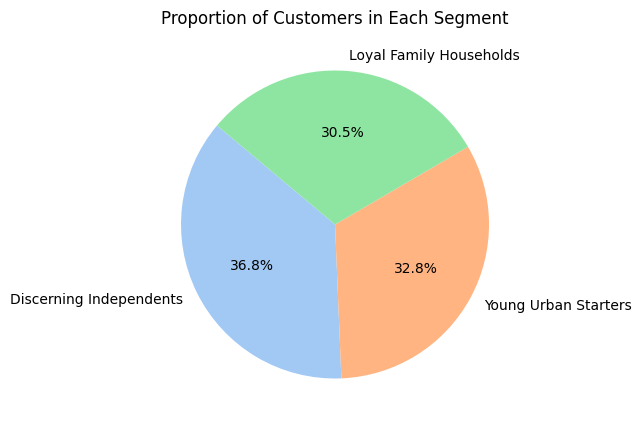

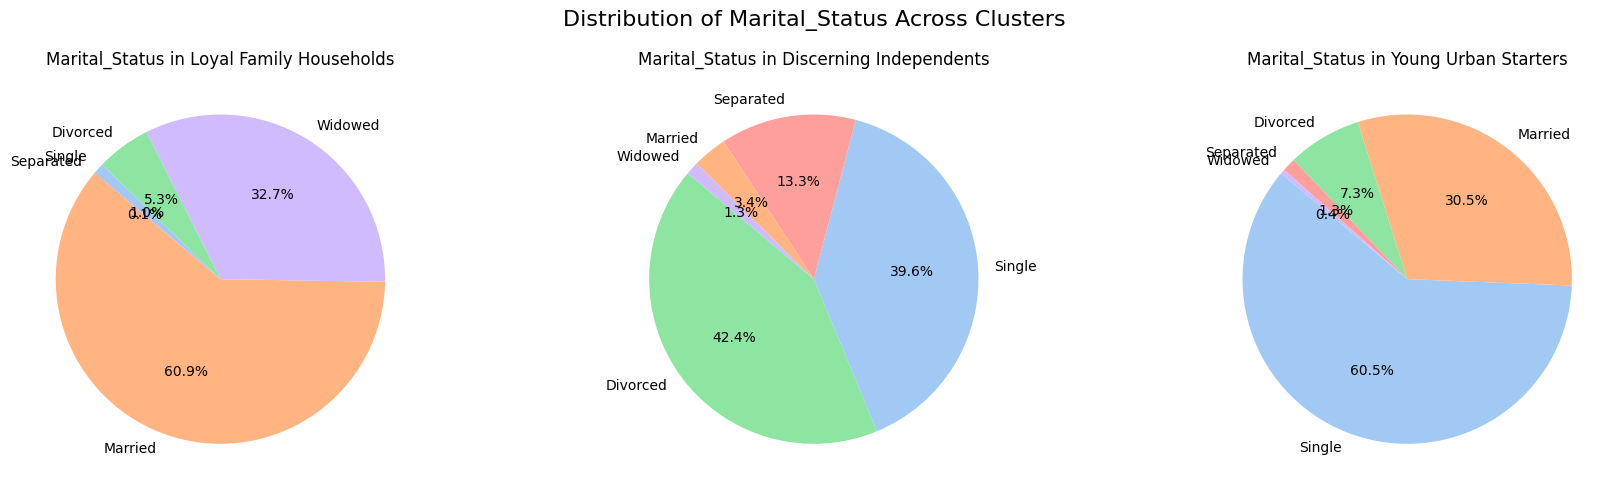

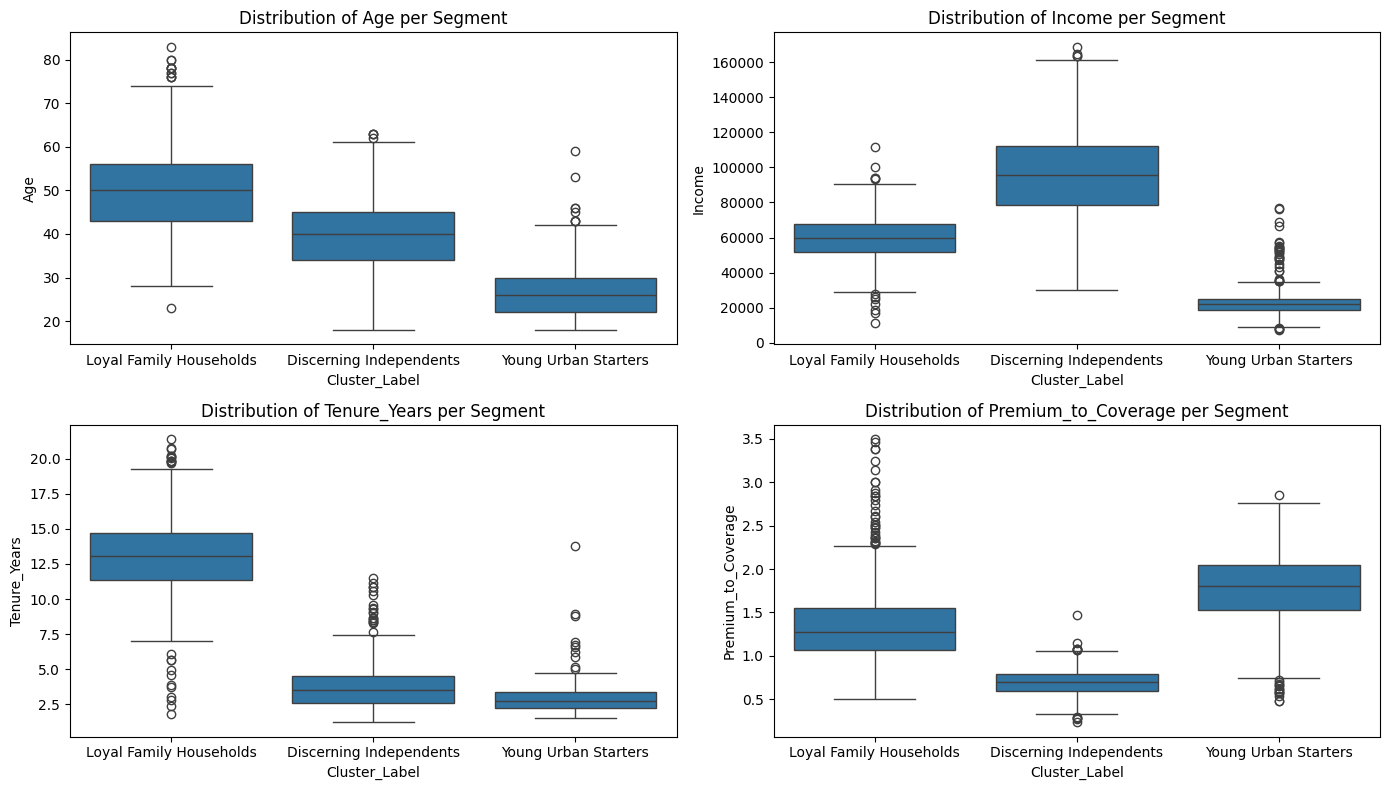

In [ ]:
# Show the proportion of customer in each segment
plt.figure(figsize=(8, 5))
value_counts = customers_clustered.iloc[:, -2].value_counts() # Counts how many customers belong to each cluster label
plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%',
        colors=sns.color_palette("pastel"), startangle=140)
plt.title("Proportion of Customers in Each Segment")
plt.show()

# Analyze the distribution of categorical features in each segment
for feature in categorical_cols:
    df_i = customers_clustered[[feature, 'Cluster_Label']].groupby(['Cluster_Label'])

    # Create consistent color map per feature
    categories = customers_clustered[feature].unique()
    palette = sns.color_palette("pastel", len(categories))
    color_map = dict(zip(categories, palette))

    # Create a new figure of subplots for each feature
    plt.figure(figsize=(18, 5))
    j = 1 # counter for the position of each subplot

    # Make a subplot for the feature distribution for each cluster
    for cluster in customers_clustered.Cluster_Label.unique():
      # Count the number of every unique items of a feature of a selected cluster
        df_c = df_i.get_group((cluster,))[feature] # extract one feature column for a selected cluster
        value_counts = df_c.value_counts() # count the number of every unique items within that feature
        # set the colours of the features
        colors = [color_map[val] for val in value_counts.index]

        plt.subplot(1, 3, j) # show 3 subplots in every row
        plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%',
                colors=colors, startangle=140)
        plt.title(f"{feature} in {cluster}")
        # move the counter by 1 for preparing making another subplot for the next cluster
        j = j + 1

    plt.suptitle(f"Distribution of {feature} Across Clusters", fontsize=16)
    plt.tight_layout()
    plt.show()


# Boxplot for numerical features
plt.figure(figsize=(14, 8))
j = 1 # counter for the position of subplot

for feature in numerical_cols:
    # Boxplot for numerical variable per cluster
    plt.subplot(2, 2, j)
    sns.boxplot(x = 'Cluster_Label', y = feature, data = customers_clustered)
    plt.title(f"Distribution of {feature} per Segment")
    j = j + 1

plt.tight_layout()
plt.show()

# (9) Load the Datasets to Google BigQuery
Finally, the updated customers, products, and sales tables are written directly to *Google BigQuery*, where the process is automated to run daily via a *GitHub Action* workflow.

In [ ]:
# Connect pandas to Google BigQuery
!pip install --upgrade pandas-gbq google-auth

In [ ]:
# Complete customer table with the sorted cluster ID
df_clustered_customers = pd.concat([df_customers, customers_clustered['Cluster_ID']], axis=1) # concatenate the columns of cluster number to the original dataset

df_clustered_customers

,Customer_ID,Age,Gender,City,Marital_Status,Education,Occupation,Income,Preferred_Language,Preferred_Channel,Preferred_Time,Cluster_ID
0,HL00001,41,Male,Sheffield,Single,Associate Degree,Lawyer,18719.316,French,Email,Afternoon,2
1,HL00002,50,Female,Manchester,Married,Doctorate,Entrepreneur,59456.052,English,Email,Afternoon,1
2,HL00003,33,Female,London,Divorced,Doctorate,Lawyer,61078.656,Arabic,Email,Morning,1
3,HL00004,43,Male,Edinburgh,Married,Master's Degree,Lawyer,39333.528,English,Email,Evening,1
4,HL00005,36,Male,Liverpool,Separated,Bachelor's Degree,Nurse,25995.516,English,Mail,Evening,2
...,...,...,...,...,...,...,...,...,...,...,...,...
3441,HL03442,42,Male,Bristol,Single,Master's Degree,Manager,48832.356,English,Email,Anytime,0
3442,HL03443,18,Male,Leeds,Divorced,Associate Degree,Doctor,127478.040,English,Email,Afternoon,1
3443,HL03444,34,Female,London,Divorced,Doctorate,Entrepreneur,97274.124,Chinese,In-Person Meeting,Morning,1
3444,HL03445,54,Female,Belfast,Married,Bachelor's Degree,Manager,66348.840,English,Phone,Anytime,2


In [ ]:
df_sales

,Policy_ID,Customer_ID,Product_ID,Purchase_Date,Premium,Coverage,Tenure_Years,Premium_to_Coverage
0,P000008,HL00008,POL200008,2022-05-04,861.832800,97928.79508,3.62,0.880061
1,P000010,HL00010,POL200016,2022-03-17,1294.144416,100724.49880,3.75,1.284836
2,P000015,HL00015,POL200017,2022-05-19,2470.369199,102937.51920,3.58,2.399872
3,P000019,HL00019,POL200018,2022-08-03,2032.112144,98439.34626,3.37,2.064329
4,P000022,HL00022,POL200015,2023-05-24,1156.180369,101259.37510,2.56,1.141801
...,...,...,...,...,...,...,...,...
3459,P003458,HL03367,POL200009,2022-01-22,5375.637343,519777.85190,3.90,1.034218
3460,P003459,HL03367,POL200001,2021-09-16,4798.328801,336051.20600,4.25,1.427856
3461,P003462,HL00347,POL200001,2011-06-26,5465.828597,382502.92070,14.48,1.428964
3462,P003463,HL00347,POL200016,2012-06-11,5015.488343,396869.88540,13.52,1.263761


In [ ]:
df_products

,Product_ID,Product_Name,Product_Type,Category
0,POL200000,WellBeing Cover,Health,Group
1,POL200001,MediAssist,Health,Group
2,POL200002,FamilyLife Plus,Life,Group
3,POL200003,LifeShield,Life,Group
4,POL200004,SecureLegacy,Life,Group
5,POL200005,DriveSure,Auto,Group
6,POL200006,TradeSecure,Property,Business
7,POL200007,AssetShield,Property,Business
8,POL200008,OfficeProtect,Property,Business
9,POL200009,MotorShield,Auto,Business


In [ ]:
X_famd # the cluster is based on the previous unsorted cluster id

component,0,1,Cluster
0,-0.279237,0.970623,0
1,0.512036,-0.307947,2
2,-0.055975,-1.068376,2
3,0.053129,-0.155772,2
4,0.155939,0.225473,0
...,...,...,...
3441,0.030294,-0.523463,1
3442,0.313372,-2.132985,2
3443,0.685990,-1.411411,2
3444,1.787690,1.221379,0


In [ ]:
# Map the old cluster ID to sorted cluster ID in X_famd
X_famd['Cluster_ID'] = X_famd['Cluster'].map(id_map)
X_famd = X_famd.drop(['Cluster'], axis = 1)

X_famd # based on the sorted new cluster_id

component,0,1,Cluster_ID
0,-0.279237,0.970623,2
1,0.512036,-0.307947,1
2,-0.055975,-1.068376,1
3,0.053129,-0.155772,1
4,0.155939,0.225473,2
...,...,...,...
3441,0.030294,-0.523463,0
3442,0.313372,-2.132985,1
3443,0.685990,-1.411411,1
3444,1.787690,1.221379,2


In [ ]:
X_famd["Cluster_ID"] = X_famd["Cluster_ID"].astype(int) # convert to string for table merge
df_labels["cluster_id"] = df_labels["cluster_id"].astype(int) # convert to string for table merge

famd_chart = X_famd.merge(
    df_labels,
    how="left",
    left_on="Cluster_ID",
    right_on="cluster_id"
)

famd_chart = famd_chart.drop(['cluster_id'], axis = 1)

In [ ]:
famd_chart

,0,1,Cluster_ID,cluster_name,description
0,-0.279237,0.970623,2,Loyal Family Households,"Mature, married, upper-middle-income individua..."
1,0.512036,-0.307947,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
2,-0.055975,-1.068376,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
3,0.053129,-0.155772,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
4,0.155939,0.225473,2,Loyal Family Households,"Mature, married, upper-middle-income individua..."
...,...,...,...,...,...
3441,0.030294,-0.523463,0,Young Urban Starters,"Young, single, budget-conscious customers new ..."
3442,0.313372,-2.132985,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
3443,0.685990,-1.411411,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
3444,1.787690,1.221379,2,Loyal Family Households,"Mature, married, upper-middle-income individua..."


In [ ]:
# converts all column names to strings
famd_chart.columns = famd_chart.columns.map(str)
famd_chart

,0,1,Cluster_ID,cluster_name,description
0,-0.279237,0.970623,2,Loyal Family Households,"Mature, married, upper-middle-income individua..."
1,0.512036,-0.307947,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
2,-0.055975,-1.068376,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
3,0.053129,-0.155772,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
4,0.155939,0.225473,2,Loyal Family Households,"Mature, married, upper-middle-income individua..."
...,...,...,...,...,...
3441,0.030294,-0.523463,0,Young Urban Starters,"Young, single, budget-conscious customers new ..."
3442,0.313372,-2.132985,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
3443,0.685990,-1.411411,1,Discerning Independents,"Middle-aged, divorced, high-income individuals..."
3444,1.787690,1.221379,2,Loyal Family Households,"Mature, married, upper-middle-income individua..."


In [ ]:
# Import the to_gbq() function from the pandas_gbq package to write
# panda dataframe to Google BigQuery tables
from pandas_gbq import to_gbq

# Write the customer dataset to BigQuery
to_gbq(
    df_clustered_customers,
    destination_table='portfolio.customers',
    project_id='new-project-456705',
    if_exists='replace'
)

# Write the sales dataset to BigQuery
to_gbq(
    df_sales,
    destination_table='portfolio.sales',
    project_id='new-project-456705',
    if_exists='replace'
)

# Write the products dataset to BigQuery
to_gbq(
    df_products,
    destination_table='portfolio.products',
    project_id='new-project-456705',
    if_exists='replace'
)

# Write the data of the 2-D clustering plot to Bigqery
to_gbq(
    famd_chart,
    destination_table='portfolio.scatter_chart',
    project_id='new-project-456705',
    if_exists='replace'
)

# Write the data of the cluster labels table to Bigqery
to_gbq(
    df_labels,
    destination_table='portfolio.df_labels',
    project_id='new-project-456705',
    if_exists='replace'
)

# Write the data of the cluster summary to Bigqery
to_gbq(
    cluster_summary_sorted,
    destination_table='portfolio.cluster_summary_sorted',
    project_id='new-project-456705',
    if_exists='replace'
)

100%|██████████| 1/1 [00:00<00:00, 12446.01it/s]
